# MNIST Image Classification using PyTorch Convolutional Neural Network

In [1]:
import numpy as np
import pandas as pd

import random

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.autograd import Variable
from torchvision.utils import make_grid
from torch.utils.data import TensorDataset, DataLoader

from sklearn.model_selection import train_test_split

import matplotlib.pyplot as plt
%matplotlib inline

import os
print(os.listdir("../input"))

FileNotFoundError: [WinError 3] The system cannot find the path specified: '../input'

# Data Acquisition

#### Load the training dataset into Pandas DataFrame

In [2]:
train = pd.read_csv('../input/train.csv')
test = pd.read_csv('../input/test.csv')


print(train.shape)
train.head()

(42000, 785)


,label,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,pixel10,pixel11,pixel12,pixel13,pixel14,pixel15,pixel16,pixel17,pixel18,pixel19,pixel20,pixel21,pixel22,pixel23,pixel24,pixel25,pixel26,pixel27,pixel28,pixel29,pixel30,pixel31,pixel32,pixel33,pixel34,pixel35,pixel36,pixel37,pixel38,...,pixel744,pixel745,pixel746,pixel747,pixel748,pixel749,pixel750,pixel751,pixel752,pixel753,pixel754,pixel755,pixel756,pixel757,pixel758,pixel759,pixel760,pixel761,pixel762,pixel763,pixel764,pixel765,pixel766,pixel767,pixel768,pixel769,pixel770,pixel771,pixel772,pixel773,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [3]:
print(test.shape)
test.head()

(28000, 784)


,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,pixel10,pixel11,pixel12,pixel13,pixel14,pixel15,pixel16,pixel17,pixel18,pixel19,pixel20,pixel21,pixel22,pixel23,pixel24,pixel25,pixel26,pixel27,pixel28,pixel29,pixel30,pixel31,pixel32,pixel33,pixel34,pixel35,pixel36,pixel37,pixel38,pixel39,...,pixel744,pixel745,pixel746,pixel747,pixel748,pixel749,pixel750,pixel751,pixel752,pixel753,pixel754,pixel755,pixel756,pixel757,pixel758,pixel759,pixel760,pixel761,pixel762,pixel763,pixel764,pixel765,pixel766,pixel767,pixel768,pixel769,pixel770,pixel771,pixel772,pixel773,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


#### Split the training dataset to features and labels


In [4]:
x_train_df = train.iloc[:,1:]
y_train_df = train.iloc[:,0]

print(x_train_df.shape, y_train_df.shape)

(42000, 784) (42000,)


#### Convert the data to numeric arrays and normalize the features

In [5]:
x_train = x_train_df.values/255.
y_train = y_train_df.values

x_test = test.values/255

#### Reshape the test and training dataset to (28,28) image arrays

In [6]:
x_train = np.reshape(x_train, (-1, 1, 28,28))
x_test = np.reshape(x_test, (-1, 1, 28,28))


x_train.shape, x_test.shape

((42000, 1, 28, 28), (28000, 1, 28, 28))

#### Split the training dataset into training and validation datasets

In [7]:
# This is to ensure reproducibility
random_seed = 234
x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size = 0.1, random_state=random_seed)


x_train.shape, x_val.shape, y_train.shape, y_val.shape

((37800, 1, 28, 28), (4200, 1, 28, 28), (37800,), (4200,))

#### Helper function to display an array of images

(28, 28)
(28, 28)
(28, 28)
(28, 28)
(28, 28)
(28, 28)
(28, 28)
(28, 28)
(28, 28)


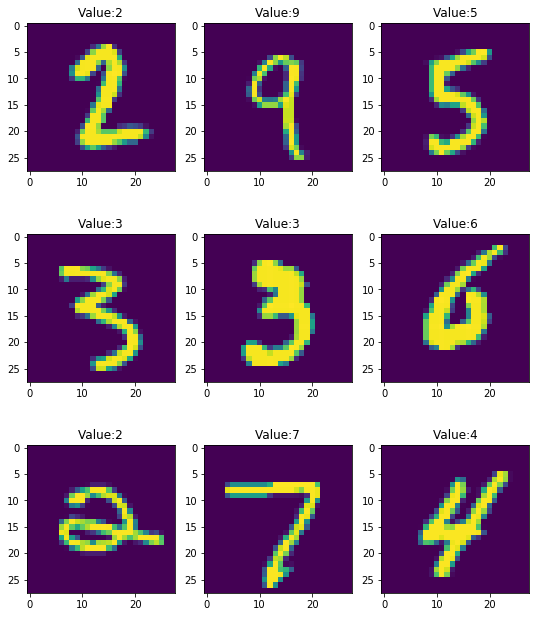

In [8]:
def display(rows, columns, images, values=[], predictions=[]):
    fig = plt.figure(figsize=(9, 11))

    ax = []

    for i in range( columns*rows ):
        img = images[i]
        ax.append(fig.add_subplot(rows, columns, i+1))
        
        title = ""
        
        if(len(values) == 0):
            title = "Pred:" + str(predictions[i])
        elif(len(predictions) == 0):
            title = "Value:" + str(values[i])
        elif(len(values) != 0 and len(predictions) != 0):
            title = "Value:" + str(values[i]) + "\nPred:" + str(predictions[i])
        
        ax[-1].set_title(title)  # set title
        plt.imshow(img)
        print(img.shape)

    plt.show()
    
idx = np.random.randint(1, 1000, size=9)

images = x_train[idx,:]
images = images[:,0]

values = y_train[idx]

display(rows=3, columns=3, images=images, values=values, predictions=[])

#### Using the GPU

In [9]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


#### Lets define the Convolutional Neural Network Model

In [10]:
class BigNet(nn.Module):
    def __init__(self):
        super(BigNet, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, kernel_size=5)
        self.conv2 = nn.Conv2d(32, 32, kernel_size=5)
        self.conv3 = nn.Conv2d(32,64, kernel_size=5)
        self.fc1 = nn.Linear(3*3*64, 256)
        self.fc2 = nn.Linear(256, 10)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.dropout(x, p=0.5, training=self.training)
        x = F.relu(F.max_pool2d(self.conv2(x), 2))
        x = F.dropout(x, p=0.5, training=self.training)
        x = F.relu(F.max_pool2d(self.conv3(x),2))
        x = F.dropout(x, p=0.5, training=self.training)
#         print("x shape before",x.shape)

        x = x.view(-1,3*3*64 )
#         print("x shape after",x.shape)

        x = F.relu(self.fc1(x))
        x = F.dropout(x, training=self.training)
        x = self.fc2(x)
        return F.log_softmax(x, dim=1)
    
bignet = BigNet()

bignet.to(device)

bignet

BigNet(
  (conv1): Conv2d(1, 32, kernel_size=(5, 5), stride=(1, 1))
  (conv2): Conv2d(32, 32, kernel_size=(5, 5), stride=(1, 1))
  (conv3): Conv2d(32, 64, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=576, out_features=256, bias=True)
  (fc2): Linear(in_features=256, out_features=10, bias=True)
)

In [12]:

class SmallNet(nn.Module):
    def __init__(self):
        super(SmallNet, self).__init__()
        self.conv1 = nn.Conv2d(1, 16, kernel_size=5)
        self.conv2 = nn.Conv2d(16, 32, kernel_size=5)
        self.fc1 = nn.Linear(3200, 10)

    def forward(self, x):
        x = F.relu(self.conv1(x), 2)
        x = F.dropout(x, p=0.5, training=self.training)
        x = F.relu(F.max_pool2d(self.conv2(x), 2))
        x = x.view(-1, 32*10*10)
        x = self.fc1(x)
        return F.log_softmax(x, dim=1)
    
smallnet = SmallNet()

smallnet.to(device)

smallnet

SmallNet(
  (conv1): Conv2d(1, 16, kernel_size=(5, 5), stride=(1, 1))
  (conv2): Conv2d(16, 32, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=3200, out_features=10, bias=True)
)

#### Lets define the optimizer and loss function

In [13]:
from torch.optim import Adam

criterion = nn.CrossEntropyLoss()
bigoptimizer = optim.SGD(bignet.parameters(), lr=0.001, momentum=0.9)
# bigoptimizer = Adam(bignet.parameters(), lr=0.001)
# smalloptimizer=Adam(smallnet.parameters(), lr=0.001)
smalloptimizer = optim.SGD(smallnet.parameters(), lr=0.001, momentum=0.9)


#### Define out tensors and dataloader

In [15]:
torch_x_train = torch.from_numpy(x_train).type(torch.FloatTensor)
torch_y_train = torch.from_numpy(y_train).type(torch.LongTensor)


train = torch.utils.data.TensorDataset(torch_x_train,torch_y_train)

train_loader = torch.utils.data.DataLoader(train, batch_size = 32, shuffle = False)

#### Train for 100 epoch

In [18]:
%%time

#Seed
torch.manual_seed(1234)

for epoch in range(10):
    running_loss = 0.0
    for i, data in enumerate(train_loader, 0):
        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)
        
        # zero the parameter gradients
        smalloptimizer.zero_grad()

        # forward + backward + optimize
        outputs = smallnet(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        smalloptimizer.step()
        
        # print statistics
        running_loss += loss.item()
        if i % 500 == 499:    # print every 500 mini-batches
            print('[%d, %5d] loss: %.3f' % (epoch + 1, i+1, loss.item()))
#             print('[%d, %5d] loss: %.3f' % (epoch + 1, i, running_loss / 500))
#             running_loss = 0.0

print('Finished Training of small net')

[1,   500] loss: 0.088
[1,  1000] loss: 0.014
[2,   500] loss: 0.087
[2,  1000] loss: 0.007
[3,   500] loss: 0.117
[3,  1000] loss: 0.003
[4,   500] loss: 0.065
[4,  1000] loss: 0.004
[5,   500] loss: 0.038
[5,  1000] loss: 0.007
[6,   500] loss: 0.045
[6,  1000] loss: 0.006
[7,   500] loss: 0.031
[7,  1000] loss: 0.009
[8,   500] loss: 0.024
[8,  1000] loss: 0.004
[9,   500] loss: 0.047
[9,  1000] loss: 0.003
[10,   500] loss: 0.029
[10,  1000] loss: 0.005
Finished Training
CPU times: user 18.9 s, sys: 560 ms, total: 19.4 s
Wall time: 19.9 s


In [ ]:
%%time

#Seed
torch.manual_seed(1234)

for epoch in range(10):
    running_loss = 0.0
    for i, data in enumerate(train_loader, 0):
        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)
        
        # zero the parameter gradients
        bigoptimizer.zero_grad()

        # forward + backward + optimize
        outputs = bignet(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        bigoptimizer.step()
        
        # print statistics
        running_loss += loss.item()
        if i % 500 == 499:    # print every 500 mini-batches
            print('[%d, %5d] loss: %.3f' % (epoch + 1, i+1, loss.item()))


print('Finished Training of bignet')

In [ ]:
def evaluate(model, dataset, max_ex=0):
    acc = 0
    model.to(device)
    N = len(dataset) * batch_size
    for i, (features, labels) in enumerate(dataset):
        features, labels=features.to(device),labels.to(device)
        scores = model(features)
        pred = torch.argmax(scores, dim=1)
        acc += torch.sum(torch.eq(pred, labels)).item()
        if max_ex != 0 and i >= max_ex:
            break
    # print(i)
    return (acc * 100 / ((i+1) * batch_size) )

In [ ]:
### Define our custom loss function
softmax_op = nn.Softmax(dim=1)
mseloss_fn = nn.MSELoss()

def my_loss(scores, targets, T=5):
    soft_pred = softmax_op(scores / T)
    soft_targets = softmax_op(targets / T)
    loss = mseloss_fn(soft_pred, soft_targets)
    return loss

Dsitilled Model

In [25]:
temperatures = [1, 2, 3, 4, 5, 7.5, 10, 15, 20]

lr = 5e-3
epochs = 10
batch_size=32
%matplotlib inline

models = {}
for temp in temperatures:
    title = 'T=' + str(temp)
    print("\n", title, "\n")
    small_model = SmallNet()
    small_model.to(device)
    optimizer = optim.SGD(small_model.parameters(), lr=0.001, momentum=0.9)

    val_acc = []
    train_acc = []
    train_loss = [-np.log(1.0 / 10)] # loss at iteration 0
    it_per_epoch = len(train_loader)
    for epoch in range(epochs):
        for i, data in enumerate(train_loader, 0):
            features,labels=data
            features, labels = features.to(device), labels.to(device)
            scores = small_model(features)
            targets = bignet(features)
            loss = my_loss(scores, targets, T = temp)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            if i %500==499:
                print('[%d, %5d] loss: %.3f' % (epoch + 1, i+1, loss.item()))

                train_acc.append(evaluate(small_model, train_loader, max_ex=100))
    #             
    train_acc.append(evaluate(small_model, train_loader, max_ex=100))
    models[title] = {'model': small_model,
                     'model_state_dict': small_model.state_dict(),
                     'optimizer_state_dict': optimizer.state_dict(),
                     'lr': lr,
                     'T': temp,
                     'loss_hist': train_loss,
                     'train_acc': train_acc,
                     'val_acc': val_acc
                     }


 T=1 

[1,   500] loss: 0.081
[1,  1000] loss: 0.082
[2,   500] loss: 0.061
[2,  1000] loss: 0.046
[3,   500] loss: 0.015
[3,  1000] loss: 0.020
[4,   500] loss: 0.011
[4,  1000] loss: 0.015
[5,   500] loss: 0.008
[5,  1000] loss: 0.014
[6,   500] loss: 0.012
[6,  1000] loss: 0.010
[7,   500] loss: 0.013
[7,  1000] loss: 0.012
[8,   500] loss: 0.009
[8,  1000] loss: 0.008
[9,   500] loss: 0.015
[9,  1000] loss: 0.005
[10,   500] loss: 0.008
[10,  1000] loss: 0.008

 T=2 

[1,   500] loss: 0.066
[1,  1000] loss: 0.068
[2,   500] loss: 0.068
[2,  1000] loss: 0.066
[3,   500] loss: 0.068
[3,  1000] loss: 0.065
[4,   500] loss: 0.064
[4,  1000] loss: 0.064
[5,   500] loss: 0.062
[5,  1000] loss: 0.061
[6,   500] loss: 0.047
[6,  1000] loss: 0.054
[7,   500] loss: 0.025
[7,  1000] loss: 0.027
[8,   500] loss: 0.016
[8,  1000] loss: 0.016
[9,   500] loss: 0.009
[9,  1000] loss: 0.014
[10,   500] loss: 0.007
[10,  1000] loss: 0.010

 T=3 

[1,   500] loss: 0.046
[1,  1000] loss: 0.047
[2,   

#### Try the model on the validation dataset

In [35]:
#Validate trained model
torch_x_val = torch.from_numpy(x_val).type(torch.FloatTensor)
torch_y_val = torch.from_numpy(y_val).type(torch.LongTensor)

torch_x_val, torch_y_val = torch_x_val.to(device), torch_y_val.to(device)
temperatures = [3, 4, 5, 7.5, 10, 15, 20]
acc_temp=[]
for temp in temperatures:
    model=SmallNet().to(device)
    model.load_state_dict(models['T=' + str(temp)]['model_state_dict'])
    print(models['T=' + str(temp)]['T'])
    val = model(torch_x_val)
    _, predicted = torch.max(val.data, 1)
    acc_temp.append(100 * torch.sum(torch_y_val==predicted) / len(y_val))
    print('Accuracy of the network %d %%' % (100 * torch.sum(torch_y_val==predicted) / len(y_val)))

3
Accuracy of the network 74 %
4
Accuracy of the network 45 %
5
Accuracy of the network 11 %
7.5
Accuracy of the network 12 %
10
Accuracy of the network 8 %
15
Accuracy of the network 12 %
20
Accuracy of the network 11 %


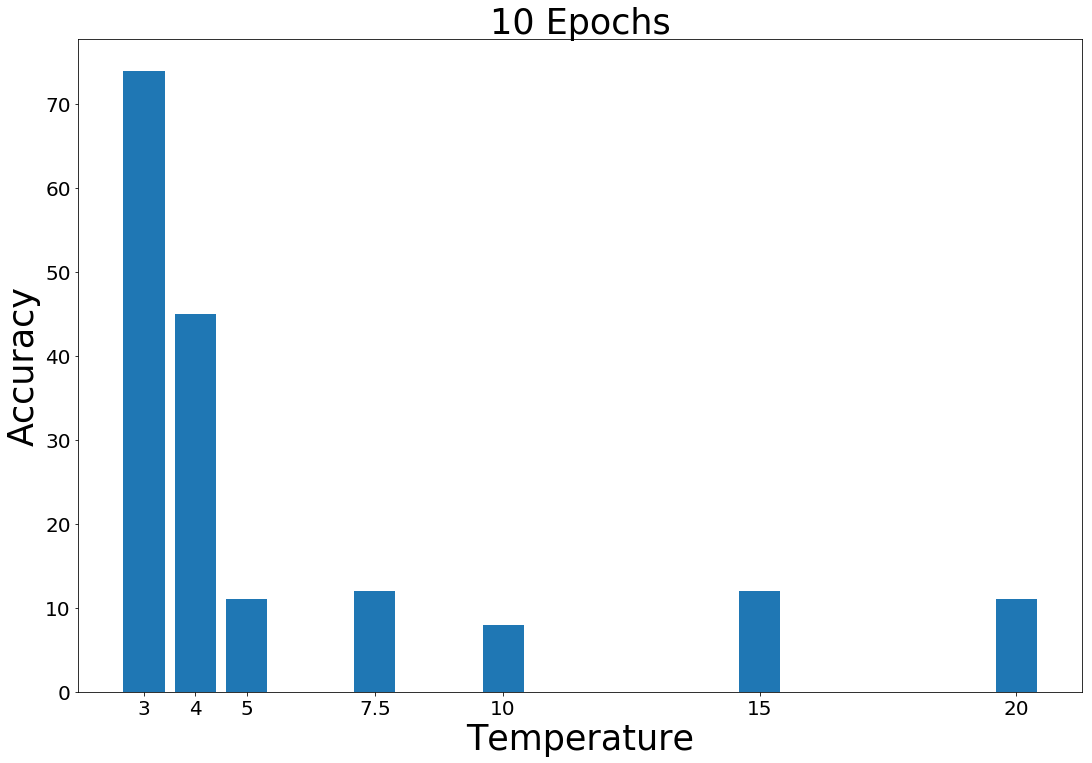

In [114]:
import matplotlib.pyplot as plt
import numpy as np

fig, ax = plt.subplots(figsize=(18,12))


xpoints = temperatures
ypoints = acc_temp
MEDIUM_SIZE = 100

plt.rc('axes', labelsize=MEDIUM_SIZE) 
ax.set_ylabel('Accuracy',fontsize = 35)
ax.set_xlabel("Temperature",fontsize = 35)
ax.set_title('10 Epochs',fontsize = 35)
ax.set_xticklabels(temperatures,fontsize = 20)

ax.set_xticks(xpoints)
plt.rc('ytick', labelsize=10)

x = np.arange(len(temperatures))
width = 0.50# the width of the bars

plt.bar(xpoints, ypoints)
# plt.show()
plt.savefig('/kaggle/working/image2.png',dpi=800)

In [23]:
#Validate trained model
torch_x_val = torch.from_numpy(x_val).type(torch.FloatTensor)
torch_y_val = torch.from_numpy(y_val).type(torch.LongTensor)

torch_x_val, torch_y_val = torch_x_val.to(device), torch_y_val.to(device)

val = bignet(torch_x_val)

_, predicted = torch.max(val.data, 1)

#Get accuration
print('Accuracy of the big network %d %%' % (100 * torch.sum(torch_y_val==predicted) / len(y_val)))

Accuracy of the network 95 %
